In [1]:
2+2

4

# Setup of LSST env

In [2]:
# ssh slacd
# source /sdf/group/rubin/sw/loadLSST.bash
# setup -k -r /sdf/home/n/ncaplar/github/analysis_ap
# setup lsst_distrib
# jupyter notebook --no-browser --port=8458 --ServerApp.token="MYTOKEN"
# forward port 8458 in vscode
# connect to http://127.0.0.1:8458/tree?token=MYTOKEN

In [2]:
# to check that we have analysis_ap
!eups list -s

afw                   g9c22b2923f+e2510deafe 	d_2024_05_05 current w_2024_18 d_2024_05_03 d_latest w_latest d_2024_05_04 setup
alert_packet          gb80f75460d 	d_2024_04_29 d_2024_05_04 d_2024_03_29 w_2024_16 d_2024_04_23 d_2024_04_24 d_2024_03_24 d_2024_04_21 d_2024_04_15 d_2024_04_01 w_2024_12 d_2024_04_10 d_2024_03_30 d_latest d_2024_03_26 d_2024_04_19 d_2024_05_03 d_2024_04_03 w_2024_13 d_2024_04_07 v27_0_0_rc1 d_2024_04_17 d_2024_03_22 w_2024_18 w_2024_17 current d_2024_04_20 d_2024_04_05 w_latest d_2024_03_23 d_2024_04_02 d_2024_04_14 d_2024_04_27 d_2024_05_01 d_2024_04_16 d_2024_04_06 d_2024_04_08 w_2024_15 d_2024_05_05 d_2024_04_30 d_2024_04_13 w_2024_14 d_2024_04_26 d_2024_03_31 d_2024_03_25 d_2024_04_28 setup
analysis_ap           LOCAL:/sdf/home/n/ncaplar/github/analysis_ap 	setup
analysis_drp          gefe92d13dd+bff92f70c2 	w_latest current w_2024_18 setup
analysis_tools        g6a935c4068+dbf0ae30d7 	w_latest w_2024_18 current setup
ap_association        g719b61f9b9+c91

# Loading of the data 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
# find which ones are variable
df_single_ps = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_7789.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]
df_single_ps_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_flux_7789.parquet')

In [6]:
ra_min, ra_max = [np.min(df_single_ps['ra']),np.max(df_single_ps['ra'])]
dec_min, dec_max = [np.min(df_single_ps['dec']),np.max(df_single_ps['dec'])]

In [7]:
# find where the detections are
import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb

repo = '/repo/embargo'
butler = dafButler.Butler(repo)
schema = 'pp_apdb_lsstcomcamsim'

# https://rubinobs.atlassian.net/browse/DM-43908
#schema = 'elhoward_dm43098_lsstcomcamsim_appipe'
instrument = 'LSSTComCamSim'
apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)

# load a part of the database, via apdbQuery
# pp_source_table_good = apdbQuery.load_sources(exclude_flagged=True, limit=2*1e5)
# pp_object_table_latest = apdbQuery.load_objects(limit=1e5) 

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [208]:
# lets not use apdbQuery
"""

pp_object_table_apdbQuery= apdbQuery.load_objects(limit=None) 
# this confirm we got all of the objects because it is less than 2e7
print(len(pp_object_table_apdbQuery))
print(len(np.unique(pp_object_table_apdbQuery['diaObjectId']))/len(pp_object_table_apdbQuery))
"""

924567
0.9994743485328808


pp_apdb_lsstcomcamsim
83745
0.9998805898859633


(array([12454.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 71291.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

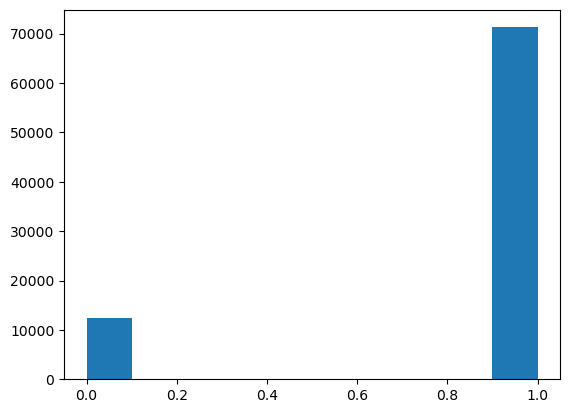

In [377]:
# this code was just to confirm that values are just 0 or 1 in the object table

"""
with apdbQuery.connection as connection:
    pp_object_table_viaSQL = pd.read_sql_query(f'''
    SELECT "diaObjectId", "ra", "dec", "flags", "nDiaSources"
    FROM "{schema}"."DiaObject"
    WHERE "ra" BETWEEN {ra_min} AND {ra_max}
      AND "dec" BETWEEN {dec_min} AND {dec_max}
      AND "validityEnd" IS NULL
    LIMIT 20000000;
    ''', connection)
    
print(schema)
print(len(pp_object_table_viaSQL))
print(len(np.unique(pp_object_table_viaSQL['diaObjectId']))/len(pp_object_table_viaSQL))
plt.hist(pp_object_table_viaSQL['flags'])
"""

In [378]:
# this does not work 
"""
schema = 'elhoward_dm43098_lsstcomcamsim_appipe'
apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)
pp_object_table_apdbQuery_rerun= apdbQuery.load_objects(limit=2e7) 
# this confirm we got all of the objects
print(len(pp_object_table_apdbQuery_rerun))
print(len(np.unique(pp_object_table_apdbQuery_rerun['diaObjectId']))/len(pp_object_table_apdbQuery_rerun))
"""
# this fails because:
apdbQuery._tables

{'DiaSource': Table('DiaSource', MetaData(), Column('diaSourceId', BIGINT(), table=<DiaSource>, primary_key=True, nullable=False), Column('ccdVisitId', BIGINT(), table=<DiaSource>, nullable=False), Column('diaObjectId', BIGINT(), table=<DiaSource>), Column('ssObjectId', BIGINT(), table=<DiaSource>), Column('parentDiaSourceId', BIGINT(), table=<DiaSource>), Column('ssObjectReassocTime', TIMESTAMP(), table=<DiaSource>), Column('midpointMjdTai', DOUBLE_PRECISION(precision=53), table=<DiaSource>, nullable=False), Column('ra', DOUBLE_PRECISION(precision=53), table=<DiaSource>, nullable=False), Column('raErr', DOUBLE_PRECISION(precision=53), table=<DiaSource>), Column('dec', DOUBLE_PRECISION(precision=53), table=<DiaSource>, nullable=False), Column('decErr', DOUBLE_PRECISION(precision=53), table=<DiaSource>), Column('ra_dec_Cov', DOUBLE_PRECISION(precision=53), table=<DiaSource>), Column('x', DOUBLE_PRECISION(precision=53), table=<DiaSource>, nullable=False), Column('xErr', DOUBLE_PRECISION(

In [8]:
repo = '/repo/embargo'
butler = dafButler.Butler(repo)
instrument = 'LSSTComCamSim'
schema = f'elhoward_dm43098_lsstcomcamsim_appipe'

apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

with apdbQuery.connection as connection:
    pp_source_table = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai", \
                                 "psfFlux", "psfFluxErr", \
                                 "scienceFlux", "scienceFluxErr", "snr", \
                                 "flags", "band" \
                                 FROM "{}"."DiaSource" \
                                 LIMIT 3000000;'.format(schema), connection)

with apdbQuery.connection as connection:
    pp_object_table = pd.read_sql_query(f'''
    SELECT "diaObjectId", "ra", "dec", "flags", "nDiaSources"
    FROM "{schema}"."DiaObject"
    WHERE "ra" BETWEEN {ra_min} AND {ra_max}
    AND "dec" BETWEEN {dec_min} AND {dec_max}
    AND "validityEnd" IS NULL
    LIMIT 1000000;
    ''', connection)


In [9]:
# why are they so repeated! - variability start is different
len(np.unique(pp_object_table['diaObjectId']))/len(pp_object_table['diaObjectId'])

0.9972794544399304

Text(0.5, 0, 'number of diaSource per diaObject')

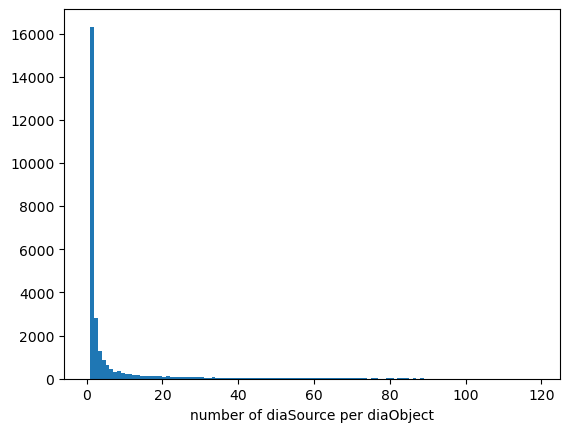

In [12]:
plt.hist(pp_object_table['nDiaSources'], bins = np.arange(0,120,1))
plt.xlabel('number of diaSource per diaObject')

In [225]:
print(len(pp_source_table))
pp_source_table_good = pp_source_table[pp_source_table['flags']==0]
print(len(pp_source_table_good))

3000000
1147177


In [226]:
min_time = np.min(pp_source_table['midpointMjdTai'])
min_time
print(min_time)

# we set it manually, just so that our results do not change if something happens
min_time = 60402.98075824075

60402.98075824075


(array([16651.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 73615.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

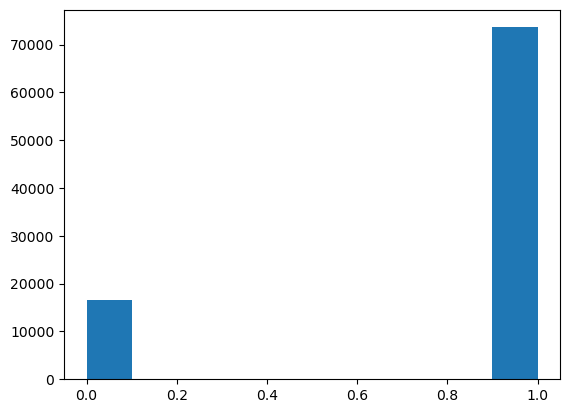

In [372]:
plt.hist(pp_object_table['flags'].values)

In [101]:
# very custom code !!! get just one field 
pp_object_table_latest_one_f = pp_object_table[pp_object_table['ra']<130]
pp_source_table_latest_one_f = pp_source_table_good[pp_source_table_good['ra']<130]

In [227]:
# this is to figure out which healpy corresponds to the observations
import healpy as hp
ra_cent = np.median(pp_object_table['ra'])
dec_cent = np.median(pp_object_table['dec'])
dec_cent

vec = hp.ang2vec(np.deg2rad((np.abs(dec_cent) + 90)), np.deg2rad(ra_cent) )
print(vec)

ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(2) )
ipix_disc

[-0.55409324  0.79115614 -0.25894525]


array([7660, 7788, 7789, 7916])

In [232]:
# find which ones are variable
df_single_ps = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_7660.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]
df_single_ps_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_flux_7660.parquet')

tru_obj = df_single_ps_var
dia_obj = pp_object_table

tru_obj_zoom = tru_obj[(tru_obj['ra']<125.35) & (tru_obj['ra']>124.6) & (tru_obj['dec']<-14.6) & (tru_obj['dec']>-15.2) ]
dia_obj_zoom = dia_obj[(dia_obj['ra']<125.35) & (dia_obj['ra']>124.6) & (dia_obj['dec']<-14.6) & (dia_obj['dec']>-15.2) ]

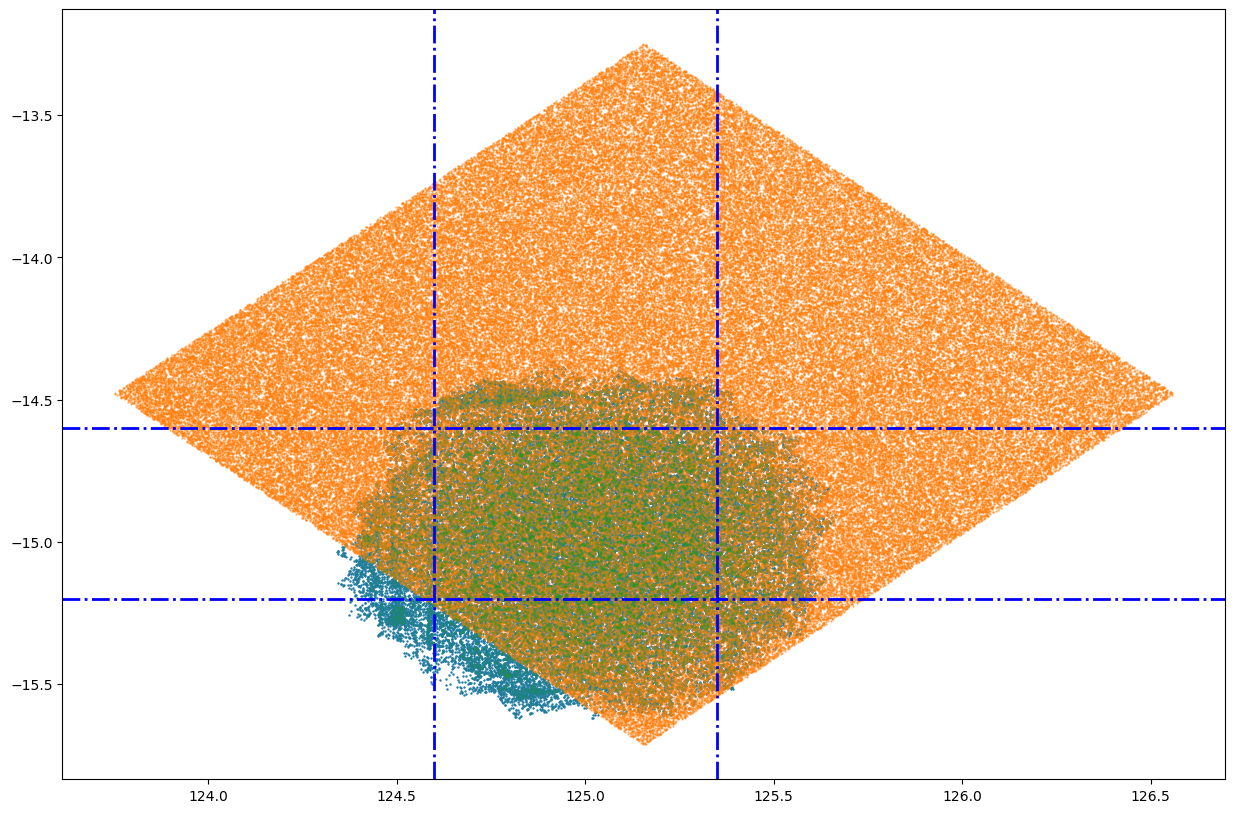

In [233]:
plt.figure(figsize=(15,10))
plt.scatter(dia_obj['ra'], dia_obj['dec'], s=0.5, label = 'diaObj')

plt.axhline(y=-14.6, color='b', linestyle='-.', linewidth=2)  # Draw a horizontal line
plt.axhline(y=-15.2, color='b', linestyle='-.', linewidth=2)  # Draw a horizontal line

plt.axvline(x=124.6, color='b', linestyle='-.', linewidth=2)  # Draw a vertical line
plt.axvline(x=125.35, color='b', linestyle='-.', linewidth=2)  # Draw a vertical line

plt.scatter(df_single_ps['ra'], df_single_ps['dec'], s=0.5, alpha=0.5, label = 'truObj')

plt.scatter(pp_object_table['ra'], pp_object_table['dec'], s=0.1, alpha=0.2, label = 'diaSources')

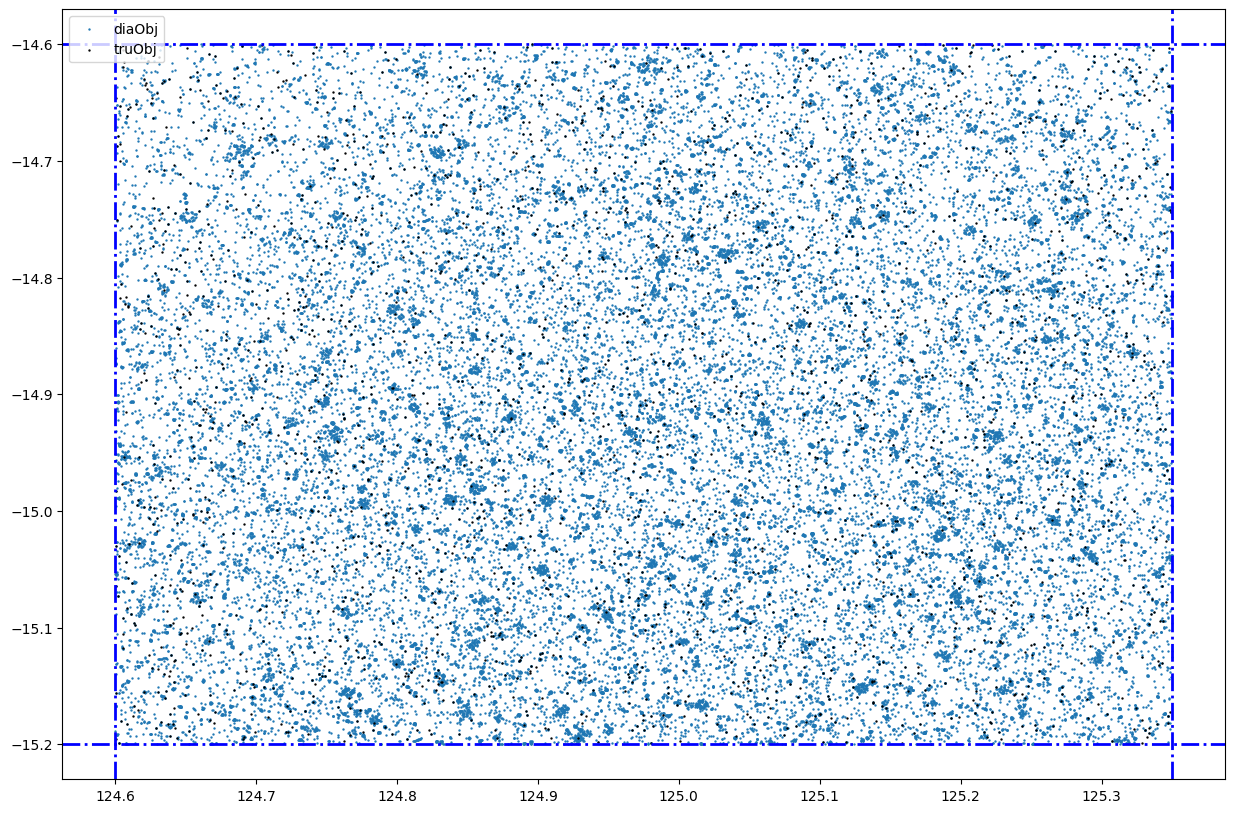

In [234]:
plt.figure(figsize=(15,10))
plt.scatter(dia_obj_zoom['ra'], dia_obj_zoom['dec'], s=0.5, label = 'diaObj')

plt.axhline(y=-14.6, color='b', linestyle='-.', linewidth=2)  # Draw a horizontal line
plt.axhline(y=-15.2, color='b', linestyle='-.', linewidth=2)  # Draw a horizontal line

plt.axvline(x=124.6, color='b', linestyle='-.', linewidth=2)  # Draw a vertical line
plt.axvline(x=125.35, color='b', linestyle='-.', linewidth=2)  # Draw a vertical line

plt.scatter(tru_obj_zoom['ra'], tru_obj_zoom['dec'], s=0.5, alpha=1, label = 'truObj',color = 'black')

plt.legend()

# Match dia to truth

In [235]:
# to match the two tables

import astropy.units as u
from astropy.coordinates import SkyCoord
# code from https://docs.astropy.org/en/stable/coordinates/matchsep.html

match_value = 1

# observations
dia_obj_zoom_SC = SkyCoord(ra=dia_obj_zoom['ra'].values*u.degree, dec=dia_obj_zoom['dec'].values*u.degree) 
# truth table
tru_obj_zoom_SC = SkyCoord(ra=tru_obj_zoom['ra'].values*u.degree, dec=tru_obj_zoom['dec'].values*u.degree)
# match the observations to the truth
idx, d2d, d3d = dia_obj_zoom_SC.match_to_catalog_sky(tru_obj_zoom_SC)
idx_close = idx[d2d.to(u.arcsec).value<match_value]

matches = dia_obj_zoom.iloc[idx]
matches_close = dia_obj_zoom.iloc[idx_close]
len(matches_close)

2562

Text(0, 0.5, 'dec [deg]')

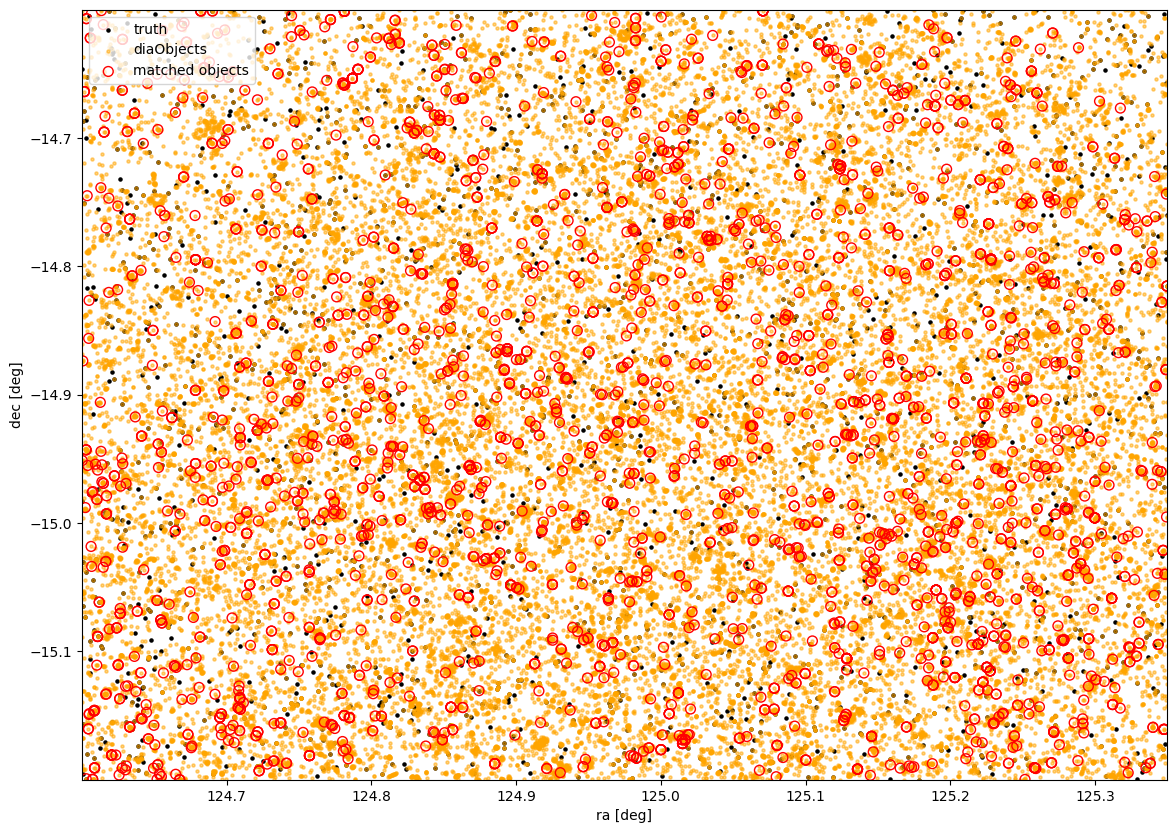

In [236]:
plt.figure(figsize = (14,10))
plt.scatter(tru_obj_zoom['ra'], tru_obj_zoom['dec'], s=5, label = 'truth', color = 'black')
plt.scatter(dia_obj_zoom['ra'], dia_obj_zoom['dec'], s= 5, color = 'orange', label = 'diaObjects', alpha = 0.5)
plt.scatter(matches_close['ra'], matches_close['dec'], s=50, label = 'matched objects', facecolors='none', edgecolors='r')

plt.legend()
plt.xlim(np.min(matches['ra']), np.max(matches['ra']))
plt.ylim(np.min(matches['dec']), np.max(matches['dec']))

plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

In [237]:
plt.figure(figsize = (14,10))
plt.scatter(tru_obj_zoom['ra'], tru_obj_zoom['dec'], s=10, label = 'truth', color = 'black')
plt.scatter(matches_close['ra'], matches_close['dec'], s=100, label = 'matched objects', facecolors='none', edgecolors='r')
plt.scatter(dia_obj_zoom['ra'], dia_obj_zoom['dec'], s= 10, color = 'orange', label = 'diaObjects')
plt.legend()
#plt.xlim(np.min(matches['ra']), np.max(matches['ra']))
#plt.ylim(np.min(matches['dec']), np.max(matches['dec']))

plt.xlim(125, 125.1)
plt.ylim(-15, -14.9)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

Text(0, 0.5, 'dec [deg]')

Text(0.5, 1.0, 'distance of diaObj to closest truObj [arcsec]')

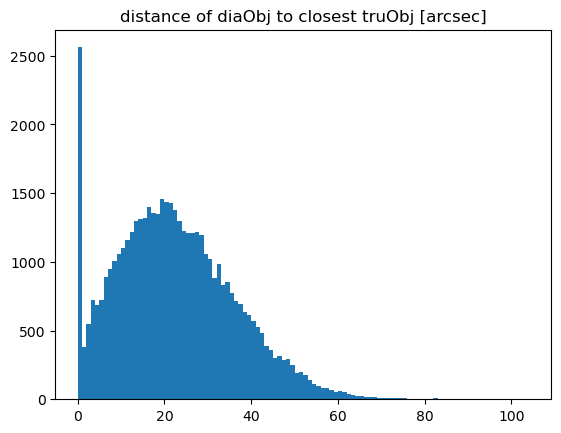

In [238]:
# distance of matches in arcsec
plt.hist(d2d.to(u.arcsec).value,bins=np.arange(0,105,1))
plt.title('distance of diaObj to closest truObj [arcsec]')

In [239]:
# fraction of diaObjects that are in the truth table
np.sum(d2d.to(u.arcsec).value < 3)/len(d2d)

0.07191900863935338

# Match truth to dia

In [240]:
# fraction of objects in the truth table that are detected 
# match the truth table to detected
idx, d2d, d3d = tru_obj_zoom_SC.match_to_catalog_sky(dia_obj_zoom_SC)
idx_close = idx[d2d.to(u.arcsec).value<match_value]
idx_far = idx[d2d.to(u.arcsec).value>match_value]

# this goes into dia_obj table
matches = dia_obj_zoom.iloc[idx]
matches_close = dia_obj_zoom.iloc[idx_close]

# this table is not really interesting
matches_not_close = dia_obj_zoom.iloc[idx_far]

# how to get tru_obj
tru_obj_match = tru_obj_zoom[d2d.to(u.arcsec).value<match_value]
tru_obj_nonmatch = tru_obj_zoom[d2d.to(u.arcsec).value>match_value]

print("Number of truObj that did match is %d" % len(tru_obj_match))
print("Number of truObj that did not match is %d" % len(tru_obj_nonmatch))


Number of truObj that did match is 1553
Number of truObj that did not match is 871


In [241]:
d2d.to(u.arcsec).value<3

array([ True,  True, False, ...,  True, False,  True])

In [242]:
# fraction of truth objects that are in diaObject table
# defined as found a match in 1 arcsec
np.sum(d2d.to(u.arcsec).value < match_value)/len(d2d)

0.6406765676567657

Text(0.5, 1.0, 'distance of truObj to closest diaObj [arcsec]')

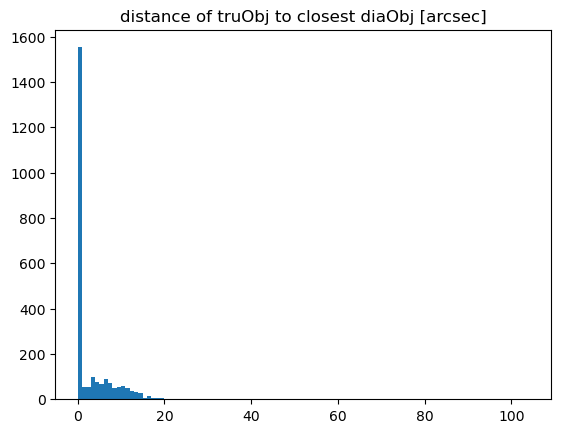

In [243]:
# distance of matches in arcsec
plt.hist(d2d.to(u.arcsec).value,bins=np.arange(0,105,1))
plt.title('distance of truObj to closest diaObj [arcsec]')

Text(0, 0.5, 'dec [deg]')

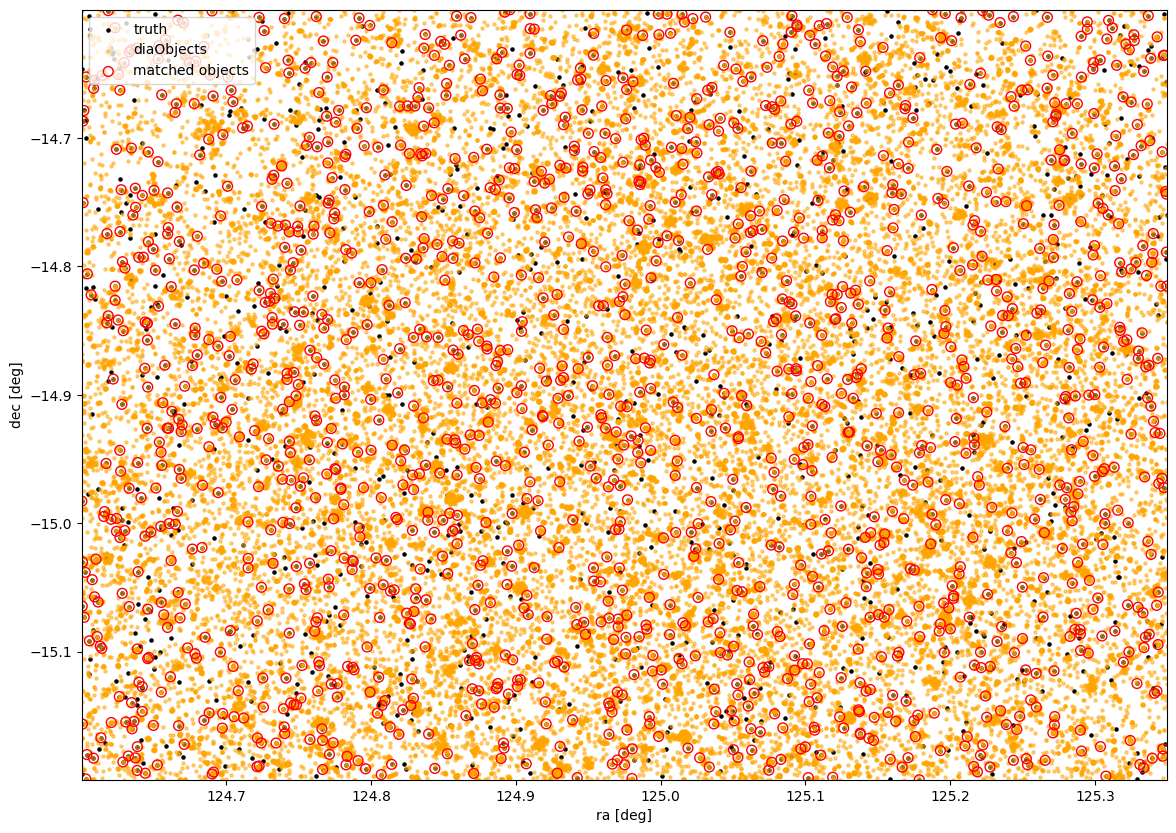

In [244]:
plt.figure(figsize = (14,10))
plt.scatter(tru_obj_zoom['ra'], tru_obj_zoom['dec'], s=5, label = 'truth', color = 'black')
plt.scatter(dia_obj_zoom['ra'], dia_obj_zoom['dec'], s= 5, color = 'orange', label = 'diaObjects', alpha = 0.5)
plt.scatter(matches_close['ra'], matches_close['dec'], s=50, label = 'matched objects', facecolors='none', edgecolors='r')

plt.legend()
plt.xlim(np.min(matches['ra']), np.max(matches['ra']))
plt.ylim(np.min(matches['dec']), np.max(matches['dec']))

plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

Text(0, 0.5, 'dec [deg]')

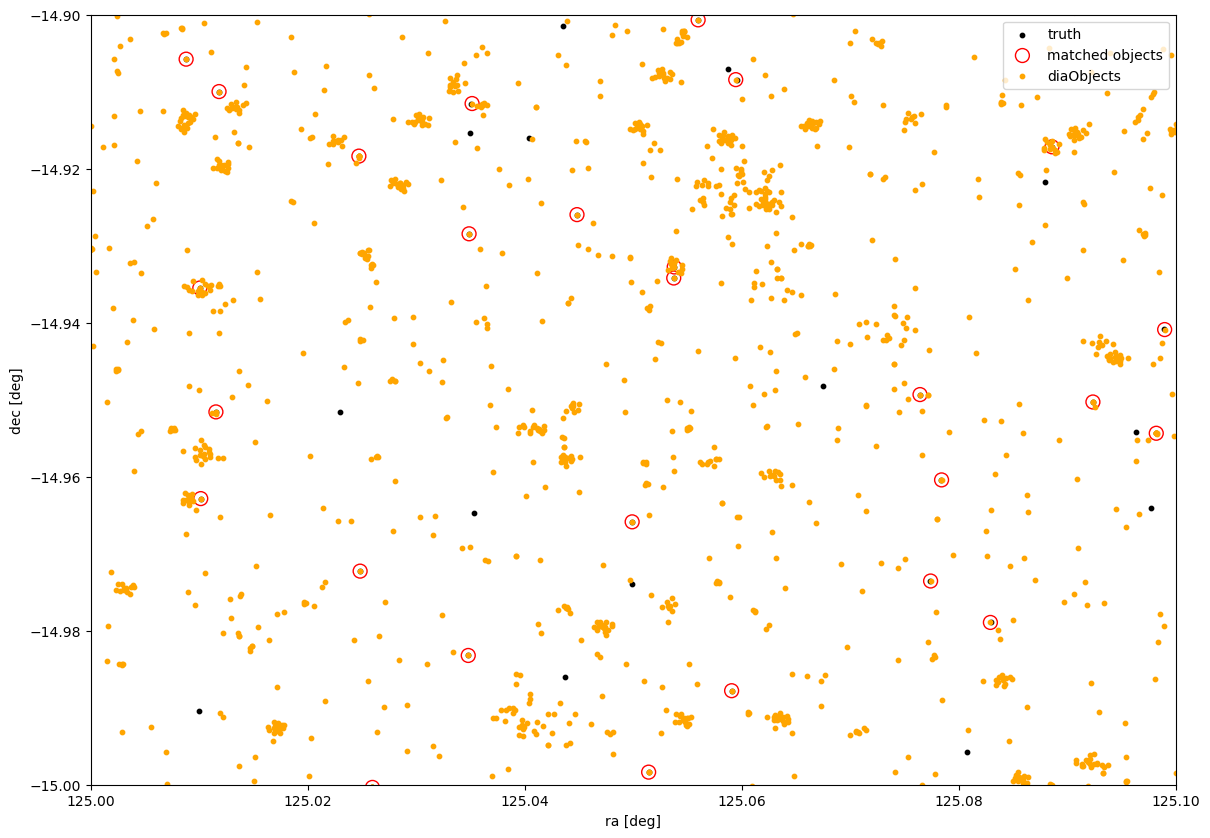

In [245]:
plt.figure(figsize = (14,10))
plt.scatter(df_single_ps_var['ra'], df_single_ps_var['dec'], s=10, label = 'truth', color = 'black')
plt.scatter(matches_close['ra'], matches_close['dec'], s=100, label = 'matched objects', facecolors='none', edgecolors='r')
plt.scatter(pp_object_table_latest_one_f['ra'], pp_object_table_latest_one_f['dec'], s= 10, color = 'orange', label = 'diaObjects')
plt.legend()
#plt.xlim(np.min(matches['ra']), np.max(matches['ra']))
#plt.ylim(np.min(matches['dec']), np.max(matches['dec']))

plt.xlim(125, 125.1)
plt.ylim(-15, -14.9)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

Text(0.5, 0, 'magnorm')

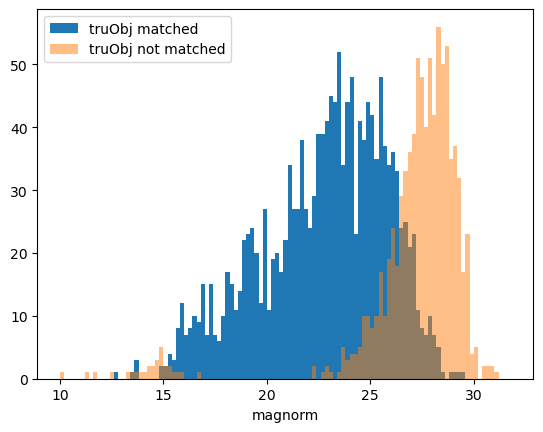

In [246]:
plt.hist(tru_obj_match['magnorm'], bins = np.arange(10,32,0.2), label = 'truObj matched')
plt.hist(tru_obj_nonmatch['magnorm'], bins = np.arange(10,32,0.2), label = 'truObj not matched', alpha = 0.5)
plt.legend()
plt.xlabel('magnorm')

In [273]:
hist2d_match,xedges, yedges, image = plt.hist2d(tru_obj_match['magnorm'],tru_obj_match['mag_amplitude'], bins = [np.arange(10,32,1),np.arange(0.1,1,0.1)]);
hist2d_nonmatch,xedges, yedges, image = plt.hist2d(tru_obj_nonmatch['magnorm'],tru_obj_nonmatch['mag_amplitude'], bins = [np.arange(10,32,1),np.arange(0.1,1,0.1)]);
hist2d_match = hist2d_match.T
hist2d_nonmatch = hist2d_nonmatch.T
plt.close()

/lscratch/ncaplar/ipykernel_1808675/3957888580.py:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow(hist2d_match/(hist2d_match+hist2d_nonmatch), extent=extent, origin='lower', aspect='auto')


Text(0, 0.5, 'mag_amplitude')

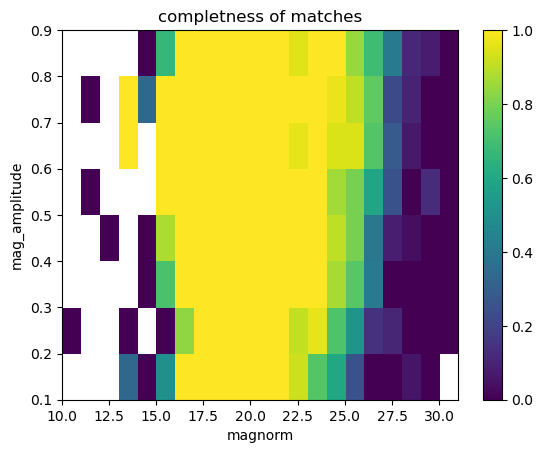

In [274]:
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(hist2d_match/(hist2d_match+hist2d_nonmatch), extent=extent, origin='lower', aspect='auto')
plt.colorbar()
plt.title('completness of matches')
plt.xlabel('magnorm')
plt.ylabel('mag_amplitude')

# Around each of true variable source do a small cone search for diaObjects

In [434]:
# Find how many of tru variables have multiple diaObjects
idx2, d2d2, d3d2 = tru_obj_zoom_SC.match_to_catalog_sky(dia_obj_zoom_SC, nthneighbor=2)
idx_close2 = idx2[d2d2.to(u.arcsec).value<match_value]
idx_far2 = idx2[d2d2.to(u.arcsec).value>match_value]

# this goes into dia_obj table
matches2 = dia_obj_zoom.iloc[idx2]
matches_close2 = dia_obj_zoom.iloc[idx_close2]

# how to get tru_obj
tru_obj_match2 = tru_obj_zoom[d2d2.to(u.arcsec).value<match_value]
tru_obj_nonmatch2 = tru_obj_zoom[d2d2.to(u.arcsec).value>match_value]
print('Match value is %f arcsec' % match_value)
print("Number of truObj that did match is %d" % len(tru_obj_match))
print("Number of truObj that had a close second match is %d" % len(tru_obj_match2))
print("Number of truObj that did not match is %d" % len(tru_obj_nonmatch))
print("Number of truObj that did not have a close second match is %d" % len(tru_obj_nonmatch2))

Match value is 1.000000 arcsec
Number of truObj that did match is 1553
Number of truObj that had a close second match is 551
Number of truObj that did not match is 871
Number of truObj that did not have a close second match is 1873


In [435]:
tru_obj_match2

object_type         id          ra        dec  host_galaxy_id  \
5975         star  254521054  124.868153 -15.107009               0   
5986         star  928878282  124.872274 -15.106681               0   
6014         star  779050829  124.894937 -15.133071               0   
6029         star  254531973  124.887342 -15.127747               0   
6030         star  928882438  124.886531 -15.128919               0   
...           ...        ...         ...        ...             ...   
86415        star  778965212  125.051435 -14.778004               0   
86443        star  254420531  125.025114 -14.711744               0   
86445        star  778939261  125.015514 -14.720505               0   
86469        star  254429343  125.014286 -14.744150               0   
86597        star  778964317  125.032457 -14.786817               0   

         magnorm                                       sed_filepath  MW_rv  \
5975   27.604506  starSED/phoSimMLT/lte027-2.0-0.0a+0.0.BT-Settl...    3.1   
5986   26.676024  starSED/phoSimMLT/lte033-4.5-1.0a+0.4.BT-Settl...    3.1   
6014   23.295023  starSED/phoSimMLT/lte033-4.5-1.0a+0.4.BT-Settl...    3.1   
6029   26.286706  starSED/phoSimMLT/lte027-2.0-0.0a+0.0.BT-Settl...    3.1   
6030   20.928099  starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...    3.1   
...          ...                                                ...    ...   
86415  21.409945          starSED/kurucz/km10_4500.fits_g05_4720.gz    3.1   
86443  22.331689  starSED/phoSimMLT/lte035-5.0-1.0a+0.4.BT-Settl...    3.1   
86445  23.305062  starSED/phoSimMLT/lte039-6.0-0.5a+0.2.BT-Settl...    3.1   
86469  21.485380  starSED/phoSimMLT/lte037-5.5-0.5a+0.2.BT-Settl...    3.1   
86597  23.365900  starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...    3.1   

          MW_av  mura  mudec  radial_velocity  parallax variability_model  \
5975   0.207343 -3.40   1.75        86.110001  0.679829                     
5986   0.210723  0.71  -0.28        58.209999  0.163682                     
6014   0.206216  3.25  -3.22        59.490002  0.624022                     
6029   0.208470 -6.25   1.38        74.459999  0.477309                     
6030   0.201708 -1.75 -14.76        -9.900000  0.780189                     
...         ...   ...    ...              ...       ...               ...   
86415  0.200581 -0.75  -0.36        67.510002  0.178731                     
86443  0.197201  0.04   2.43        59.599998  0.575440                     
86445  0.198328 -1.44  -0.89        69.910004  0.217170                     
86469  0.198328 -1.23  -7.47        21.639999  0.640030                     
86597  0.201708 -3.15  -0.84        68.160004  0.249919                     

      salt2_params  is_variable    period  mag_amplitude     phase  
5975          None         True  0.315333       0.981032  1.970687  
5986          None         True  1.470644       0.229372  0.953312  
6014          None         True  0.305328       0.548804  1.335844  
6029          None         True  5.361102       0.302484  4.111869  
6030          None         True  0.176544       0.782131  2.034605  
...            ...          ...       ...            ...       ...  
86415         None         True  2.950352       0.678572  4.477751  
86443         None         True  3.280458       0.367077  1.327730  
86445         None         True  9.948103       0.438206  5.437042  
86469         None         True  0.188643       0.514938  5.979706  
86597         None         True  0.558863       0.455042  0.659980  

[551 rows x 19 columns]

Text(0.5, 1.0, 'Do diaObjects around objTru have a second match')

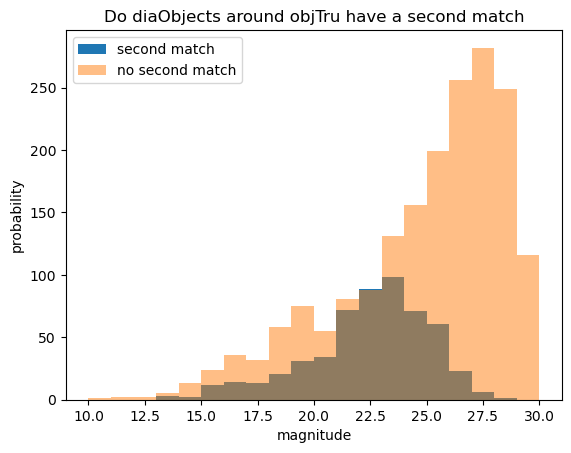

In [436]:
# properties of the close second match object

plt.hist(tru_obj_match2['magnorm'], bins = np.arange(10,31), label = 'second match')
plt.hist(tru_obj_nonmatch2['magnorm'],bins = np.arange(10,31), alpha = 0.5, label = 'no second match')
plt.legend()
plt.xlabel('magnitude')
plt.ylabel('probability')
plt.title('Do diaObjects around objTru have a second match')

In [527]:
# let us look around one of these objects
# 24
single_mul_match = tru_obj_match2.iloc[95]
single_mul_match


object_type                                                       star
id                                                           928871234
ra                                                          124.725776
dec                                                         -15.143275
host_galaxy_id                                                       0
magnorm                                                      23.828089
sed_filepath         starSED/phoSimMLT/lte034-4.5-1.0a+0.4.BT-Settl...
MW_rv                                                              3.1
MW_av                                                         0.226499
mura                                                             -2.36
mudec                                                             3.16
radial_velocity                                              91.610001
parallax                                                      0.372563
variability_model                                                     
salt2_

In [528]:
# which diaObjects around a single truObj

diaObj_single_truObj = dia_obj_zoom[ (dia_obj_zoom['ra'] < single_mul_match['ra']+1/3600) & (dia_obj_zoom['ra'] > single_mul_match['ra']-1/3600) & \
    (dia_obj_zoom['dec'] < single_mul_match['dec']+1/3600) & (dia_obj_zoom['dec'] > single_mul_match['dec']-1/3600)]
diaObj_single_truObj

diaObjectId          ra        dec  flags  nDiaSources
25627  3065438463349227584  124.725775 -15.143272      1           99
35139  3065473655229120789  124.725780 -15.143302      1            3

In [529]:
diaObjectId1 = diaObj_single_truObj['diaObjectId'].iloc[0]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s1_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
            "flags", "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId1}
        LIMIT 3000000;
        ''',
        connection
    )
    
diaObjectId2 = diaObj_single_truObj['diaObjectId'].iloc[1]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s2_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
            "flags", "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId2}
        LIMIT 3000000;
        ''',
        connection
    )

In [530]:
# how many sources have zero flags
n0flags = np.sum(s1_obj['flags']==0) + np.sum(s2_obj['flags']==0)
nallflags = len(s1_obj) + len(s2_obj)

n0flags/nallflags

0.883495145631068

Text(0, 0.5, 'dec [deg]')

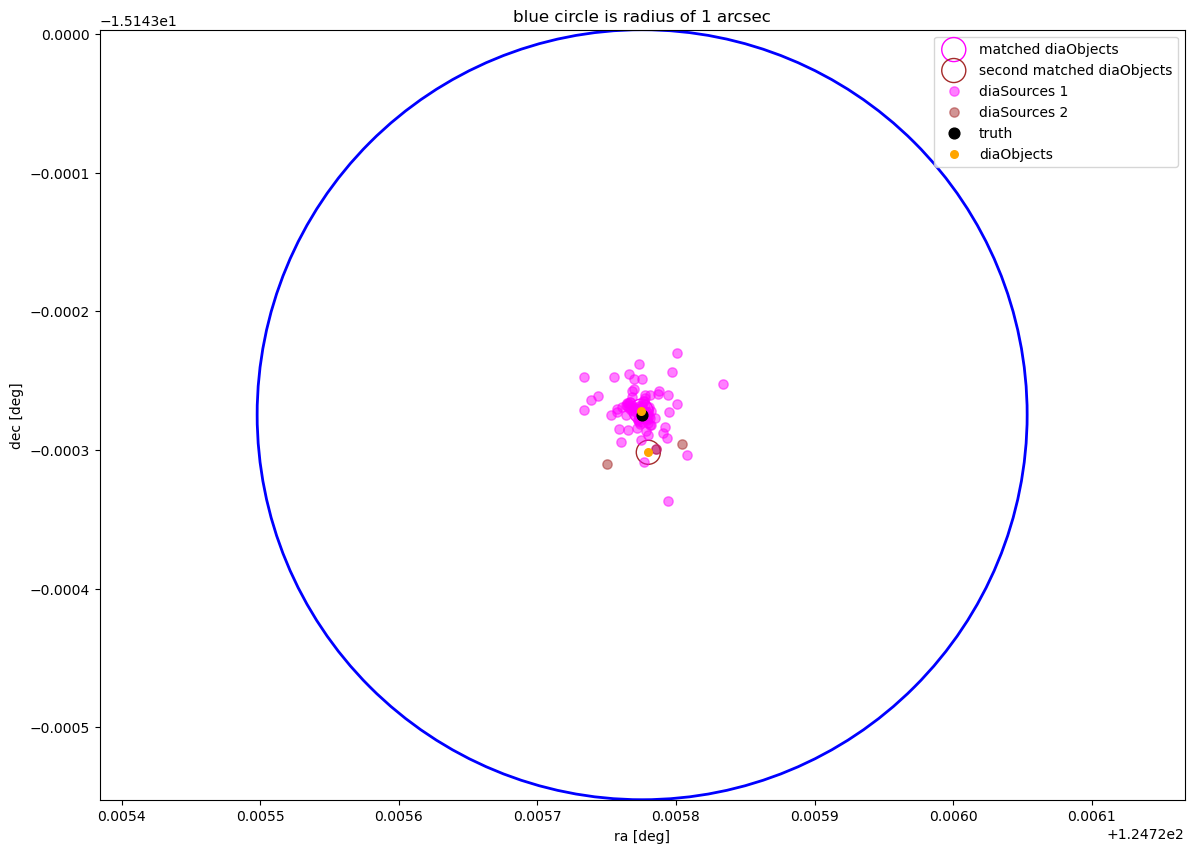

In [531]:
from matplotlib.patches import Circle

plt.figure(figsize = (14,10))

plt.scatter(matches_close['ra'], matches_close['dec'], s=300, label = 'matched diaObjects', facecolors='none', edgecolors='magenta')
plt.scatter(matches_close2['ra'], matches_close2['dec'], s=300, label = 'second matched diaObjects', facecolors='none', edgecolors='brown')

# plt.scatter(pp_source_table_latest_one_f['ra'], pp_source_table_latest_one_f['dec'], s=15, color = 'green', label = 'diaSources')


plt.scatter(s1_obj['ra'], s1_obj['dec'], s=45, color = 'magenta', label = 'diaSources 1', alpha=0.5)
plt.scatter(s2_obj['ra'], s2_obj['dec'], s=45, color = 'brown', label = 'diaSources 2', alpha=0.5)

plt.scatter(df_single_ps_var['ra'], df_single_ps_var['dec'], s=60, label = 'truth', color = 'black')
plt.scatter(pp_object_table['ra'], pp_object_table['dec'], s=30, color = 'orange', label = 'diaObjects')

plt.legend()
plt.xlim(single_mul_match['ra']-1/3600, single_mul_match['ra']+1/3600)
plt.ylim(single_mul_match['dec']-1/3600, single_mul_match['dec']+1/3600)

circle = Circle((single_mul_match['ra'], single_mul_match['dec']), 1/3600, edgecolor='blue', facecolor='none', linewidth=2)  # Adjust the position and size as needed

current_axes = plt.gca()
current_axes.add_patch(circle)
current_axes.set_aspect('equal', adjustable='datalim')

plt.title('blue circle is radius of 1 arcsec')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

In [534]:
diaObj_single_truObj['nDiaSources'].iloc[0]

99

In [535]:
print(len(s1_obj))
print(diaObj_single_truObj['nDiaSources'].iloc[0])
print(len(s2_obj))
print(diaObj_single_truObj['nDiaSources'].iloc[1])

100
99
3
3


In [521]:
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
from lsst.utils import getPackageDir

# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath
from lsst.ap.association import UnpackApdbFlags

flag_map = os.path.join(getPackageDir("ap_association"), "data/association-flag-map.yaml")
unpacker = UnpackApdbFlags(flag_map, "DiaSource")
# flags = unpacker.unpack(pp_source_table_good["flags"], "flags")
#flagTable = pd.DataFrame(flags, index = pp_source_table_good.index )
#flagTable.loc[s1_obj.index]

In [536]:
import astropy.units as u
def create_mag_errors(sciFlux, sciFluxErr):
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    return mag, magErr

In [539]:
# magic numbers are here: https://lsstc.slack.com/archives/C054NPMH4DV/p1713816904979329?thread_ts=1713726275.459819&cid=C054NPMH4DV
g_zp = 14.689449213373276
r_zp = 14.559501946792281
i_zp = 14.378976834902065

single_mul_match.id

lsst_flux_r = df_single_ps_flux[df_single_ps_flux['id']==single_mul_match.id]['lsst_flux_r']
# lsst_mag_r = u.nJy.to(u.ABmag, lsst_flux_r) - 14.559501946792281
lsst_mag_r = r_zp - 2.5*np.log10(lsst_flux_r)

lsst_flux_i = df_single_ps_flux[df_single_ps_flux['id']==single_mul_match.id]['lsst_flux_i']
lsst_mag_i = i_zp - 2.5*np.log10(lsst_flux_i)

lsst_flux_g = df_single_ps_flux[df_single_ps_flux['id']==single_mul_match.id]['lsst_flux_g']
lsst_mag_g=g = g_zp - 2.5*np.log10(lsst_flux_g)


mjd = np.arange(min_time, min_time + 3, 3/1000)
mjd0 = 60400.0
mag_amplitude = single_mul_match['mag_amplitude']
period = single_mul_match['period']
phase = single_mul_match['phase']

magnorm_r = lsst_mag_r.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)
magnorm_i = lsst_mag_i.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)
magnorm_g = lsst_mag_g.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


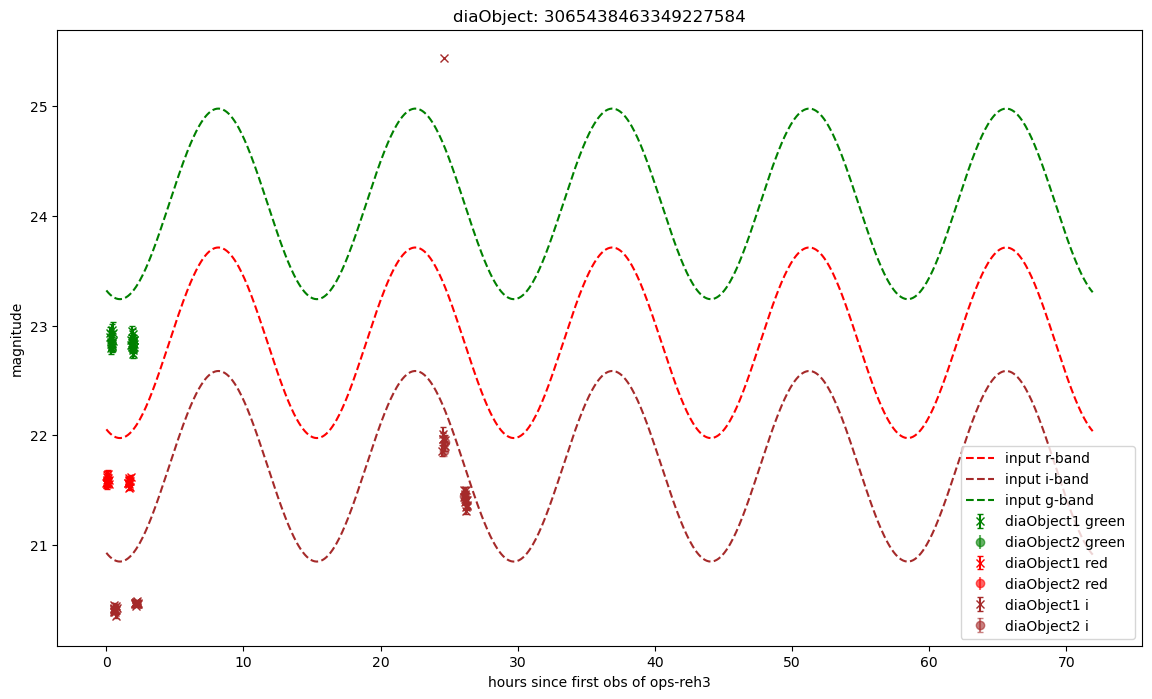

In [540]:
s1_obj_g = s1_obj[s1_obj['band']=='g']
s2_obj_g = s2_obj[s2_obj['band']=='g']

s1_obj_r = s1_obj[s1_obj['band']=='r']
s2_obj_r = s2_obj[s2_obj['band']=='r']

s1_obj_i = s1_obj[s1_obj['band']=='i']
s2_obj_i = s2_obj[s2_obj['band']=='i']

s1_mag_g, s1_mag_err_g = create_mag_errors(s1_obj_g['scienceFlux'].values, s1_obj_g['scienceFluxErr'].values)
s2_mag_g, s2_mag_err_g = create_mag_errors(s2_obj_g['scienceFlux'].values, s2_obj_g['scienceFluxErr'].values)

s1_mag_r, s1_mag_err_r = create_mag_errors(s1_obj_r['scienceFlux'].values, s1_obj_r['scienceFluxErr'].values)
s2_mag_r, s2_mag_err_r = create_mag_errors(s2_obj_r['scienceFlux'].values, s2_obj_r['scienceFluxErr'].values)

s1_mag_i, s1_mag_err_i = create_mag_errors(s1_obj_i['scienceFlux'].values, s1_obj_i['scienceFluxErr'].values)
s2_mag_i, s2_mag_err_i = create_mag_errors(s2_obj_i['scienceFlux'].values, s2_obj_i['scienceFluxErr'].values)

plt.figure(figsize=(14,8))
plt.errorbar((s1_obj_g['midpointMjdTai'].values - min_time)*24,s1_mag_g, s1_mag_err_g, marker = 'x', capsize=2, ls='none', color = 'green', label = 'diaObject1 green ')
plt.errorbar((s2_obj_g['midpointMjdTai'].values - min_time)*24,s2_mag_g, s2_mag_err_g, marker = 'o', capsize=2, ls='none', color = 'green', alpha =0.6, label = 'diaObject2 green')

plt.errorbar((s1_obj_r['midpointMjdTai'].values - min_time)*24,s1_mag_r, s1_mag_err_r, marker = 'x', capsize=2, ls='none', color = 'red', label = 'diaObject1 red ')
plt.errorbar((s2_obj_r['midpointMjdTai'].values - min_time)*24,s2_mag_r, s2_mag_err_r, marker = 'o', capsize=2, ls='none', color = 'red', alpha =0.6, label = 'diaObject2 red')

plt.errorbar((s1_obj_i['midpointMjdTai'].values - min_time)*24,s1_mag_i, s1_mag_err_i, marker = 'x', capsize=2, ls='none', color = 'brown', label = 'diaObject1 i ')
plt.errorbar((s2_obj_i['midpointMjdTai'].values - min_time)*24,s2_mag_i, s2_mag_err_i, marker = 'o', capsize=2, ls='none', color = 'brown', alpha =0.6, label = 'diaObject2 i')

plt.plot((mjd-min_time)*24, magnorm_r, color ='red', ls ='--', label = 'input r-band')
plt.plot((mjd-min_time)*24, magnorm_i, color ='brown', ls ='--', label = 'input i-band')
plt.plot((mjd-min_time)*24, magnorm_g, color ='green', ls ='--', label = 'input g-band')

plt.xlim()
plt.xlabel('hours since first obs of ops-reh3')
plt.ylabel('magnitude')

plt.title('diaObject: '+str(s1_obj['diaObjectId'].loc[0]))
plt.legend()

In [557]:
single_sin_match = tru_obj_match.iloc[105]

diaObj_single_truObj = dia_obj_zoom[ (dia_obj_zoom['ra'] < single_sin_match['ra']+1/3600) & (dia_obj_zoom['ra'] > single_sin_match['ra']-1/3600) & \
    (dia_obj_zoom['dec'] < single_sin_match['dec']+1/3600) & (dia_obj_zoom['dec'] > single_sin_match['dec']-1/3600)]
diaObj_single_truObj

diaObjectId          ra       dec  flags  nDiaSources
31905  3065473736850276656  124.754029 -15.04732      1          228

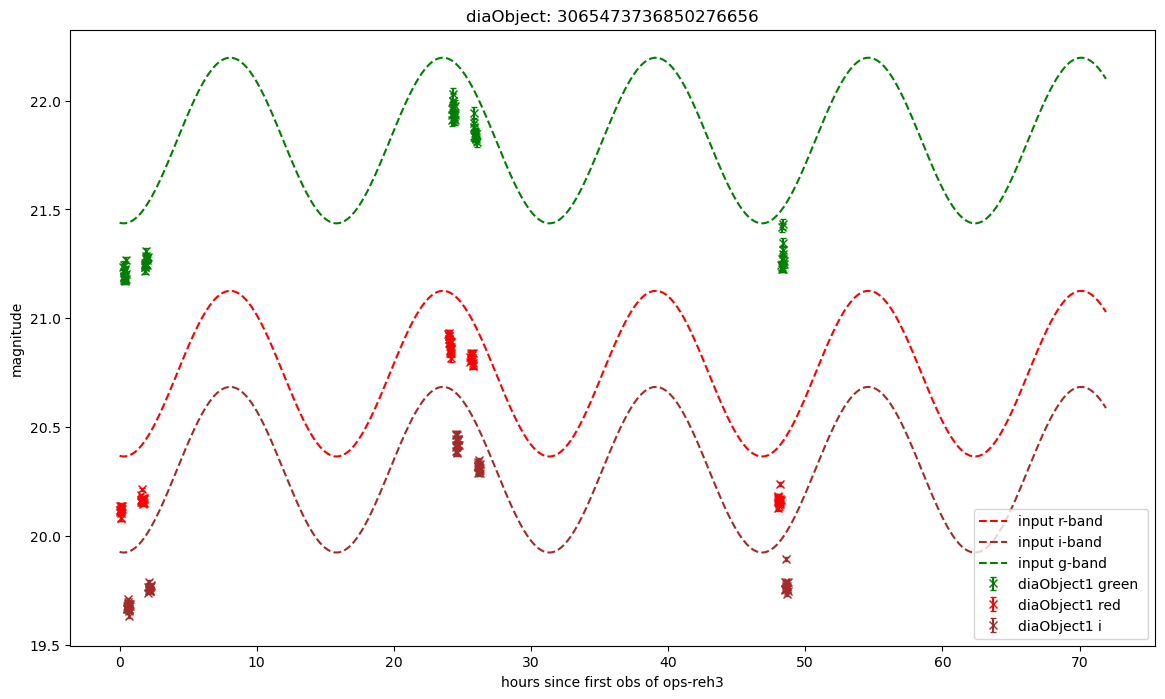

In [561]:
diaObjectId1 = diaObj_single_truObj['diaObjectId'].iloc[0]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s1_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
            "flags", "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId1}
        LIMIT 3000000;
        ''',
        connection
    )
    
# magic numbers are here: https://lsstc.slack.com/archives/C054NPMH4DV/p1713816904979329?thread_ts=1713726275.459819&cid=C054NPMH4DV
g_zp = 14.689449213373276
r_zp = 14.559501946792281
i_zp = 14.378976834902065


lsst_flux_r = df_single_ps_flux[df_single_ps_flux['id']==single_sin_match.id]['lsst_flux_r']
# lsst_mag_r = u.nJy.to(u.ABmag, lsst_flux_r) - 14.559501946792281
lsst_mag_r = r_zp - 2.5*np.log10(lsst_flux_r)

lsst_flux_i = df_single_ps_flux[df_single_ps_flux['id']==single_sin_match.id]['lsst_flux_i']
lsst_mag_i = i_zp - 2.5*np.log10(lsst_flux_i)

lsst_flux_g = df_single_ps_flux[df_single_ps_flux['id']==single_sin_match.id]['lsst_flux_g']
lsst_mag_g=g = g_zp - 2.5*np.log10(lsst_flux_g)


mjd = np.arange(min_time, min_time + 3, 3/1000)
mjd0 = 60400.0
mag_amplitude = single_sin_match['mag_amplitude']
period = single_sin_match['period']
phase = single_sin_match['phase']

magnorm_r = lsst_mag_r.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)
magnorm_i = lsst_mag_i.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)
magnorm_g = lsst_mag_g.values[0] + mag_amplitude * np.sin(2.*np.pi*(mjd - mjd0)/period + phase)


s1_obj_g = s1_obj[s1_obj['band']=='g']

s1_obj_r = s1_obj[s1_obj['band']=='r']

s1_obj_i = s1_obj[s1_obj['band']=='i']

s1_mag_g, s1_mag_err_g = create_mag_errors(s1_obj_g['scienceFlux'].values, s1_obj_g['scienceFluxErr'].values)

s1_mag_r, s1_mag_err_r = create_mag_errors(s1_obj_r['scienceFlux'].values, s1_obj_r['scienceFluxErr'].values)

s1_mag_i, s1_mag_err_i = create_mag_errors(s1_obj_i['scienceFlux'].values, s1_obj_i['scienceFluxErr'].values)

plt.figure(figsize=(14,8))
plt.errorbar((s1_obj_g['midpointMjdTai'].values - min_time)*24,s1_mag_g, s1_mag_err_g, marker = 'x', capsize=2, ls='none', color = 'green', label = 'diaObject1 green ')

plt.errorbar((s1_obj_r['midpointMjdTai'].values - min_time)*24,s1_mag_r, s1_mag_err_r, marker = 'x', capsize=2, ls='none', color = 'red', label = 'diaObject1 red ')

plt.errorbar((s1_obj_i['midpointMjdTai'].values - min_time)*24,s1_mag_i, s1_mag_err_i, marker = 'x', capsize=2, ls='none', color = 'brown', label = 'diaObject1 i ')

plt.plot((mjd-min_time)*24, magnorm_r, color ='red', ls ='--', label = 'input r-band')
plt.plot((mjd-min_time)*24, magnorm_i, color ='brown', ls ='--', label = 'input i-band')
plt.plot((mjd-min_time)*24, magnorm_g, color ='green', ls ='--', label = 'input g-band')

plt.xlim()
plt.xlabel('hours since first obs of ops-reh3')
plt.ylabel('magnitude')

plt.title('diaObject: '+str(s1_obj['diaObjectId'].loc[0]))
plt.legend()

In [50]:
"""
# To get fraction of sources that have glags

flags_in_tru_obj_match2 = []
for ix, single_mul_match  in tru_obj_match2.iterrows():
    diaObj_single_truObj = dia_obj_zoom[ (dia_obj_zoom['ra'] < single_mul_match['ra']+1/3600) & (dia_obj_zoom['ra'] > single_mul_match['ra']-1/3600) & \
        (dia_obj_zoom['dec'] < single_mul_match['dec']+1/3600) & (dia_obj_zoom['dec'] > single_mul_match['dec']-1/3600)]
    s1_obj = pp_source_table_latest_one_f[pp_source_table_latest_one_f['diaObjectId']==diaObj_single_truObj['diaObjectId'].values[0]]
    s2_obj = pp_source_table_latest_one_f[pp_source_table_latest_one_f['diaObjectId']==diaObj_single_truObj['diaObjectId'].values[1]]
    n0flags = np.sum(s1_obj['flags']==0) + np.sum(s2_obj['flags']==0)
    nallflags = len(s1_obj) + len(s2_obj)
    flags_in_tru_obj_match2.append([ix, n0flags, nallflags])

# for the diaTruth that have second diaObj
# index, number of sources without flags, total number of sources
flags_in_tru_obj_match2 = np.array(flags_in_tru_obj_match2)  


flags_in_tru_obj_match = []
for ix, single_mul_match  in tru_obj_match.iterrows():
    diaObj_single_truObj = dia_obj_zoom[ (dia_obj_zoom['ra'] < single_mul_match['ra']+1/3600) & (dia_obj_zoom['ra'] > single_mul_match['ra']-1/3600) & \
        (dia_obj_zoom['dec'] < single_mul_match['dec']+1/3600) & (dia_obj_zoom['dec'] > single_mul_match['dec']-1/3600)]
    s1_obj = pp_source_table_latest_one_f[pp_source_table_latest_one_f['diaObjectId']==diaObj_single_truObj['diaObjectId'].values[0]]
    n0flags = np.sum(s1_obj['flags']==0)
    nallflags = len(s1_obj) 
    flags_in_tru_obj_match.append([ix, n0flags, nallflags])

# for the diaTruth that have diaObj (one or two)
# index, number of sources without flags, total number of sources
flags_in_tru_obj_match = np.array(flags_in_tru_obj_match)

# fraction of sources that have flags = 0, if have two matchees 
np.sum(flags_in_tru_obj_match2[:,1])/np.sum(flags_in_tru_obj_match2[:,2])

# fraction of sources that have flags = 0, if have any match
np.sum(flags_in_tru_obj_match[:,1])/np.sum(flags_in_tru_obj_match[:,2])

"""

"\n# To get fraction of sources that have glags\n\nflags_in_tru_obj_match2 = []\nfor ix, single_mul_match  in tru_obj_match2.iterrows():\n    diaObj_single_truObj = dia_obj_zoom[ (dia_obj_zoom['ra'] < single_mul_match['ra']+1/3600) & (dia_obj_zoom['ra'] > single_mul_match['ra']-1/3600) &         (dia_obj_zoom['dec'] < single_mul_match['dec']+1/3600) & (dia_obj_zoom['dec'] > single_mul_match['dec']-1/3600)]\n    s1_obj = pp_source_table_latest_one_f[pp_source_table_latest_one_f['diaObjectId']==diaObj_single_truObj['diaObjectId'].values[0]]\n    s2_obj = pp_source_table_latest_one_f[pp_source_table_latest_one_f['diaObjectId']==diaObj_single_truObj['diaObjectId'].values[1]]\n    n0flags = np.sum(s1_obj['flags']==0) + np.sum(s2_obj['flags']==0)\n    nallflags = len(s1_obj) + len(s2_obj)\n    flags_in_tru_obj_match2.append([ix, n0flags, nallflags])\n\n# for the diaTruth that have second diaObj\n# index, number of sources without flags, total number of sources\nflags_in_tru_obj_match2 = np.a